# CCoT Neural Geometry

Pairwise cosine similarity of thought representations across three CCoT approaches:
- **NLP Logits / Input Embeds**: base GPT-2 fed ground-truth CoT text from GSM8K
- **Coconut**: SIM-CoT Coconut GPT-2 (`internlm/SIM_COT-GPT2-Coconut`)
- **CODI**: SIM-CoT CODI GPT-2 (`internlm/SIM_COT-GPT2-CODI`)

In [1]:
import sys
sys.path.insert(0, 'codi')
sys.path.insert(0, 'coconut')

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, TaskType
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file
from datasets import load_dataset

from src.model import CODI, ModelArguments
from coconut import Coconut

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [2]:
ds = load_dataset("gsm8k", "main")["test"]
N_SEQUENCES = 5

sequences = []
for i in range(N_SEQUENCES):
    cot_text, final_answer = ds[i]["answer"].split("####")
    sequences.append({"question": ds[i]["question"], "cot_text": cot_text.strip(), "final_answer": final_answer.strip()})
    print(f"[{i}] {ds[i]['question'][:80]}...")
    print(f"    Answer: {final_answer.strip()}\n")

[0] Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning an...
    Answer: 18

[1] A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bol...
    Answer: 3

[2] Josh decides to try flipping a house.  He buys a house for $80,000 and then puts...
    Answer: 70000

[3] James decides to run 3 sprints 3 times a week.  He runs 60 meters each sprint.  ...
    Answer: 540

[4] Every day, Wendi feeds each of her chickens three cups of mixed chicken feed, co...
    Answer: 20



In [3]:
nlp_model = AutoModelForCausalLM.from_pretrained("gpt2", torch_dtype=torch.bfloat16).to(device).eval()
nlp_tokenizer = AutoTokenizer.from_pretrained("gpt2")
nlp_tokenizer.pad_token = nlp_tokenizer.eos_token
print(f"NLP baseline: GPT-2 ({nlp_model.config.vocab_size} vocab, {nlp_model.config.n_embd}d)")

`torch_dtype` is deprecated! Use `dtype` instead!


NLP baseline: GPT-2 (50257 vocab, 768d)


In [4]:
# Download SIM-CoT CODI checkpoint and probe architecture
ckpt_path = hf_hub_download("internlm/SIM_COT-GPT2-CODI", "model-00001-of-00001.safetensors")
state_dict = load_file(ckpt_path)

lora_rank = next(v.shape[0] for k, v in state_dict.items() if "lora_A" in k)
prj_dim = state_dict["prj.1.weight"].shape[0]
print(f"Probed: lora_rank={lora_rank}, prj_dim={prj_dim}")

model_args = ModelArguments(model_name_or_path="gpt2", train=False, lora_init=True)

class CoDIArgs:
    bf16 = True
    num_latent = 6
    use_lora = True
    use_prj = True
    prj_dim = prj_dim
    prj_dropout = 0.0
    prj_no_ln = False
    restore_from = ""
    inf_latent_iterations = 6
    remove_eos = True
    fix_attn_mask = False
    print_loss = False
    distill_loss_div_std = False
    distill_loss_type = "smooth_l1"
    distill_loss_factor = 1.0
    ref_loss_factor = 1.0

codi_args = CoDIArgs()

lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=True,
    r=lora_rank, lora_alpha=16, lora_dropout=0.0,
    target_modules=["c_attn", "c_proj", "c_fc"], init_lora_weights=True,
)

codi_model = CODI(model_args, codi_args, lora_config)
result = codi_model.load_state_dict(state_dict, strict=False)
print(f"Missing: {len(result.missing_keys)}, Unexpected: {len(result.unexpected_keys)}")
if result.unexpected_keys:
    print(f"  Unexpected (decoder.*): {result.unexpected_keys[:3]}")

codi_model = codi_model.to(device=device, dtype=torch.bfloat16)
codi_model.eval()
codi_tokenizer = codi_model.tokenizer

Probed: lora_rank=128, prj_dim=768


/nfs/nhome/live/jbauer/venvs/ml/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/nfs/nhome/live/jbauer/venvs/ml/lib/python3.12/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Missing: 0, Unexpected: 149
  Unexpected (decoder.*): ['decoder.lm_head.weight', 'decoder.transformer.h.0.attn.c_attn.bias', 'decoder.transformer.h.0.attn.c_attn.weight']


In [5]:
# Download SIM-CoT Coconut checkpoint
coconut_ckpt_path = hf_hub_download("internlm/SIM_COT-GPT2-Coconut", "checkpoint_28")
coconut_state = torch.load(coconut_ckpt_path, map_location="cpu", weights_only=False)
print(f"Coconut checkpoint: {len(coconut_state)} keys")
print(f"  First 3: {sorted(coconut_state.keys())[:3]}")

# Build Coconut model: base GPT-2 + special tokens
coconut_base = AutoModelForCausalLM.from_pretrained("gpt2", torch_dtype=torch.bfloat16)
coconut_tokenizer = AutoTokenizer.from_pretrained("gpt2")
coconut_tokenizer.pad_token = coconut_tokenizer.eos_token
coconut_tokenizer.add_tokens(["<|start-latent|>", "<|end-latent|>", "<|latent|>"])
coconut_base.resize_token_embeddings(len(coconut_tokenizer))

start_id = coconut_tokenizer.convert_tokens_to_ids("<|start-latent|>")
end_id = coconut_tokenizer.convert_tokens_to_ids("<|end-latent|>")
latent_id = coconut_tokenizer.convert_tokens_to_ids("<|latent|>")
print(f"Special tokens: start={start_id}, end={end_id}, latent={latent_id}")

coconut_model = Coconut(coconut_base, latent_id, start_id, end_id, coconut_tokenizer.eos_token_id)

# Strip FSDP/DDP prefix if present
first_key = next(iter(coconut_state))
if first_key.startswith("_fsdp_wrapped_module."):
    coconut_state = {k.removeprefix("_fsdp_wrapped_module."): v for k, v in coconut_state.items()}
elif first_key.startswith("module."):
    coconut_state = {k.removeprefix("module."): v for k, v in coconut_state.items()}

result = coconut_model.load_state_dict(coconut_state, strict=False)
print(f"Missing: {len(result.missing_keys)}, Unexpected: {len(result.unexpected_keys)}")

coconut_model = coconut_model.to(device=device, dtype=torch.bfloat16)
coconut_model.eval()
C_THOUGHT, MAX_LATENT_STAGE = 2, 3
print(f"Coconut: {C_THOUGHT * MAX_LATENT_STAGE} latent positions")

Coconut checkpoint: 299 keys
  First 3: ['base_causallm.lm_head.weight', 'base_causallm.transformer.h.0.attn.c_attn.bias', 'base_causallm.transformer.h.0.attn.c_attn.weight']
Special tokens: start=50257, end=50258, latent=50259
Missing: 0, Unexpected: 149
Coconut: 6 latent positions


In [6]:
@torch.no_grad()
def extract_nlp_representations(question, cot_text, model, tokenizer):
    text = f"Question: {question}\n{cot_text}"
    inputs = tokenizer(text, return_tensors="pt").to(device)
    logits = model(**inputs).logits[0].float().cpu()                         # (N, 50257)
    probs = logits.softmax(dim=-1)                                           # (N, 50257) in [0,1)
    input_embeds = model.transformer.wte(inputs["input_ids"])[0].float().cpu()  # (N, 768)
    tokens = [tokenizer.decode([t]) for t in inputs["input_ids"][0]]
    return probs, input_embeds, tokens

@torch.no_grad()
def extract_codi_thoughts(question, model, args):
    tok = model.tokenizer
    ids = tok(question, return_tensors="pt").to(device)
    bot = torch.tensor([[model.bot_id]], device=device)
    input_ids = torch.cat([ids["input_ids"], bot], dim=1)
    attn = torch.cat([ids["attention_mask"], torch.ones_like(bot)], dim=1)

    thoughts, labels = [], []
    out = model.codi(input_ids=input_ids, attention_mask=attn, use_cache=True, output_hidden_states=True)
    pkv = out.past_key_values
    h = out.hidden_states[-1][:, -1, :]
    thoughts.append(h.float().cpu()); labels.append("Enc")
    latent = model.prj(h.unsqueeze(1)) if model.use_prj else h.unsqueeze(1)

    for i in range(args.inf_latent_iterations):
        out = model.codi(inputs_embeds=latent, use_cache=True, output_hidden_states=True, past_key_values=pkv)
        pkv = out.past_key_values
        h = out.hidden_states[-1][:, -1, :]
        thoughts.append(h.float().cpu()); labels.append(f"L{i+1}")
        latent = model.prj(h.unsqueeze(1)) if model.use_prj else h.unsqueeze(1)

    return torch.stack(thoughts).squeeze(1), labels  # (7, 768)

@torch.no_grad()
def extract_coconut_thoughts(question, model, tokenizer, c_thought, max_stage):
    n_latent = c_thought * max_stage
    q_toks = tokenizer.encode(question, add_special_tokens=False)
    ids = torch.tensor(
        [q_toks + [model.start_latent_id] + [model.latent_token_id] * n_latent + [model.end_latent_id]],
        device=device,
    )
    attn = torch.ones_like(ids)
    labels = torch.full_like(ids, -100)
    pos = torch.arange(ids.shape[1], device=device).unsqueeze(0)

    outputs = model(ids, attn, labels, pos)
    start = len(q_toks) + 1  # after <|start-latent|>
    thoughts = outputs.inputs_embeds[0, start:start + n_latent, :].float().cpu()
    return thoughts, [f"T{i+1}" for i in range(n_latent)]  # (6, 768)

def dot_product_matrix(X):
    """Mean-subtract rows, then raw dot product."""
    X = X.float()
    X = X - X.mean(dim=0, keepdim=True)
    return (X @ X.T).numpy()

In [7]:
all_results = []
for seq in tqdm(sequences, desc="Extracting"):
    logits, embeds, tokens = extract_nlp_representations(seq["question"], seq["cot_text"], nlp_model, nlp_tokenizer)
    codi_thoughts, codi_labels = extract_codi_thoughts(seq["question"], codi_model, codi_args)
    coconut_thoughts, coconut_labels = extract_coconut_thoughts(seq["question"], coconut_model, coconut_tokenizer, C_THOUGHT, MAX_LATENT_STAGE)

    all_results.append({
        "question": seq["question"],
        "nlp_logits_sim": dot_product_matrix(logits),
        "nlp_embeds_sim": dot_product_matrix(embeds),
        "codi_sim": dot_product_matrix(codi_thoughts),
        "coconut_sim": dot_product_matrix(coconut_thoughts),
        "nlp_tokens": tokens,
        "codi_labels": codi_labels,
        "coconut_labels": coconut_labels,
    })
    print(f"  NLP: {logits.shape[0]} toks | CODI: {codi_thoughts.shape} | Coconut: {coconut_thoughts.shape}")

Extracting:   0%|          | 0/5 [00:00<?, ?it/s]

  NLP: 117 toks | CODI: torch.Size([7, 768]) | Coconut: torch.Size([6, 768])
  NLP: 69 toks | CODI: torch.Size([7, 768]) | Coconut: torch.Size([6, 768])
  NLP: 169 toks | CODI: torch.Size([7, 768]) | Coconut: torch.Size([6, 768])
  NLP: 67 toks | CODI: torch.Size([7, 768]) | Coconut: torch.Size([6, 768])
  NLP: 191 toks | CODI: torch.Size([7, 768]) | Coconut: torch.Size([6, 768])


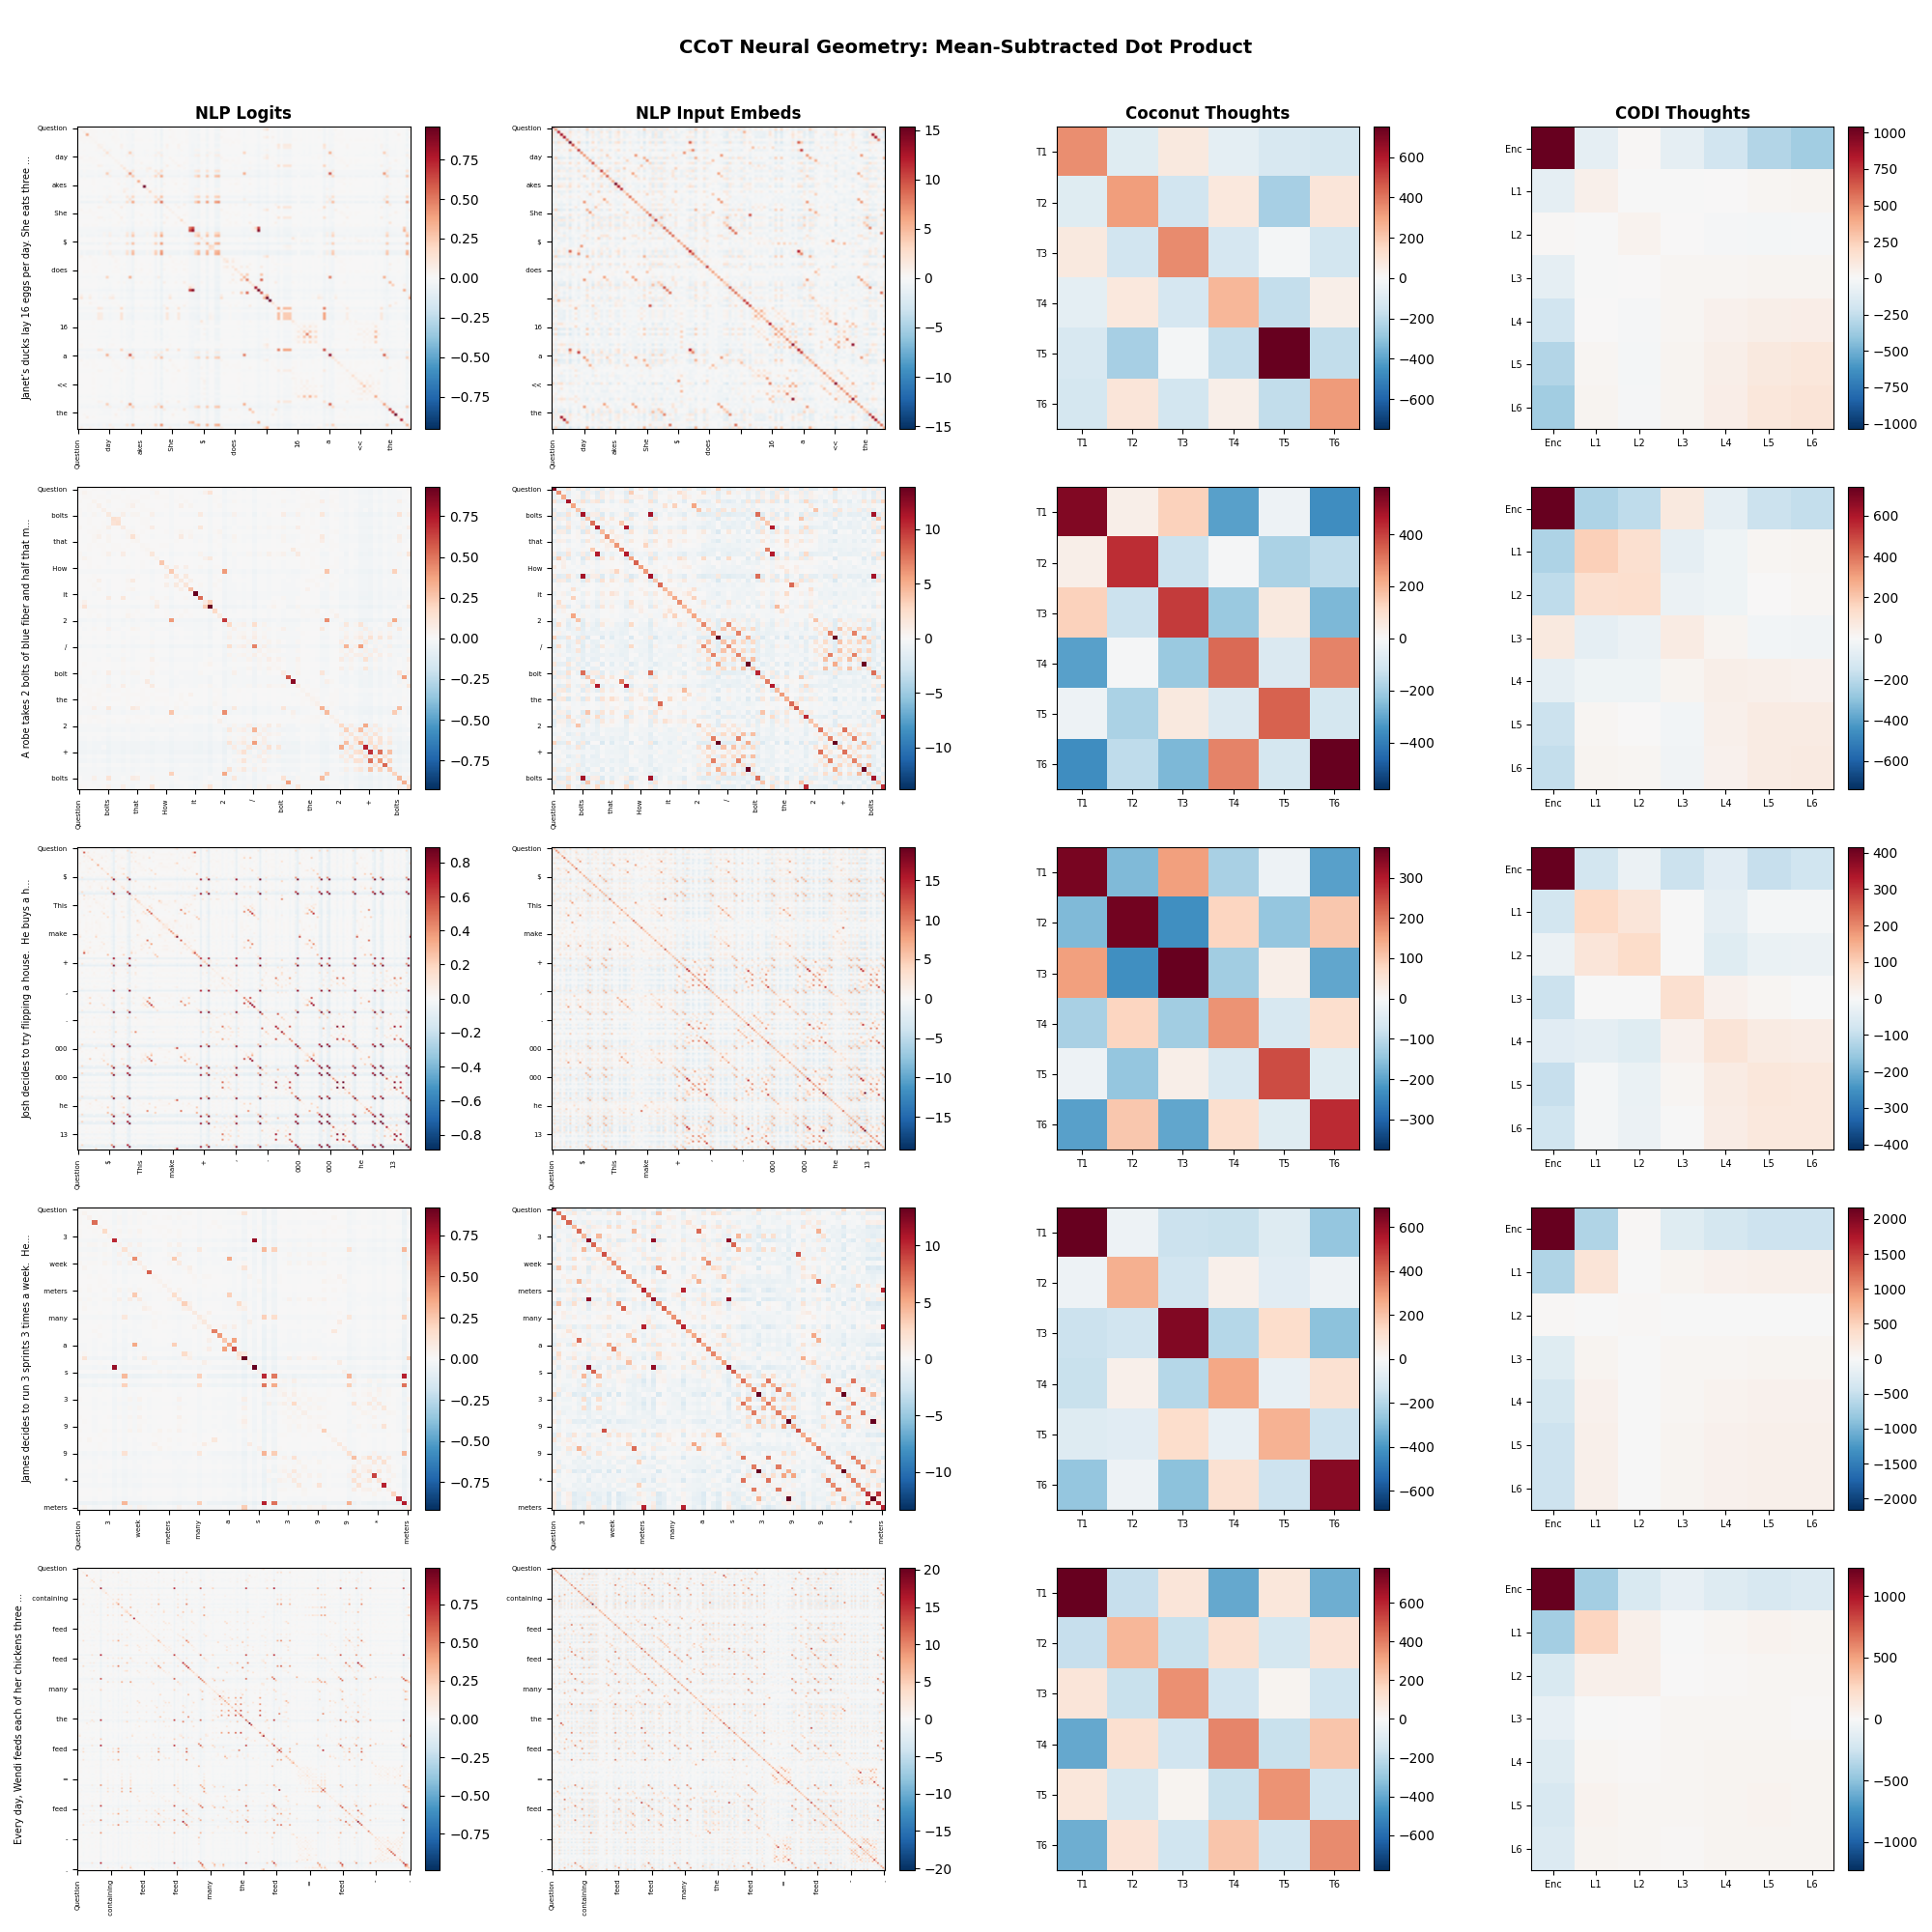

In [8]:
n = len(all_results)
fig, axes = plt.subplots(n, 4, figsize=(20, 4 * n))
titles = ["NLP Logits", "NLP Input Embeds", "Coconut Thoughts", "CODI Thoughts"]
panels = [
    ("nlp_logits_sim", "nlp_tokens"),
    ("nlp_embeds_sim", "nlp_tokens"),
    ("coconut_sim", "coconut_labels"),
    ("codi_sim", "codi_labels"),
]

for i, res in enumerate(all_results):
    for j, (sk, lk) in enumerate(panels):
        ax = axes[i, j]
        sim, labs = res[sk], res[lk]
        vlim = np.abs(sim).max()
        im = ax.imshow(sim, cmap="RdBu_r", vmin=-vlim, vmax=vlim)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        if sk.startswith("nlp"):
            ax.set_aspect("auto")
            step = max(1, len(labs) // 10)
            ticks = list(range(0, len(labs), step))
            ax.set_xticks(ticks); ax.set_xticklabels([labs[t] for t in ticks], rotation=90, fontsize=5)
            ax.set_yticks(ticks); ax.set_yticklabels([labs[t] for t in ticks], fontsize=5)
        else:
            ax.set_aspect("equal")
            ax.set_xticks(range(len(labs))); ax.set_xticklabels(labs, fontsize=7)
            ax.set_yticks(range(len(labs))); ax.set_yticklabels(labs, fontsize=7)

        if i == 0: ax.set_title(titles[j], fontsize=12, fontweight="bold")
        if j == 0: ax.set_ylabel(res["question"][:50] + "...", fontsize=7)

fig.suptitle("CCoT Neural Geometry: Mean-Subtracted Dot Product", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("ccot_geometry.png", dpi=150, bbox_inches="tight")
plt.show()